# **Introduction**

***Howdy, Welcome to the Titanic***

**To whom does this notebook appeal to?**<br><br>
If you are just starting with WNNC's HELLO FOSS and want to do beginner task in ML, you can try this project!

Data reading, visualization and pre-processing has been done for you. We need you to use logistic regression using sklearn library to predict whether or not they survived the sinking of the Titanic. We have also included `gender_submission.csv`, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Head over to [this cell](#main) to implement logistic regression and then add code for writing the output to file `predictions-ann.csv` [here](#main2). 

![](https://faithmag.com/sites/default/files/styles/article_full/public/2018-09/titanic2.jpg?h=6521bd5e&itok=H8td6QVv)

**Basic Imports**

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

import os
files = [f for f in os.listdir('./titanic/')]
for f in files:
        print(f)



ouput.csv
gender_submission.csv
train.csv
test.csv


# Reading In the Data

We will be first importing the data, and creating copies. I recommend this because it give you access to a clean untouched base file.
Next, we will be dropping some things that we don't need such as passenger Id and Ticket price

In [4]:
train_data = pd.read_csv('./titanic/train.csv')
test_data = pd.read_csv('./titanic/test.csv')
#make a copy so your original data is not touched
train = train_data.copy()
test = test_data.copy()
train.shape
y_train = train['Survived']

#We won't need passenger ID or ticket price for the model! They do not provide much insight on the training.
Id = pd.DataFrame(test['PassengerId'])
train.drop(['PassengerId'], axis = 1, inplace=True)
test.drop(['PassengerId'], axis = 1, inplace=True)
train.drop(['Survived'], axis = 1, inplace=True)
train.drop(['Ticket'], axis = 1, inplace=True)
test.drop(['Ticket'], axis = 1, inplace=True)

**Let's take a look at our data!**

In [5]:
train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


**Lets see how many null values there are! We need to fill out these values later.**

**We see that we have some midding values from age, and a ton missing from cabin**

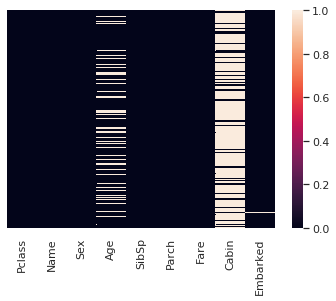

In [6]:
sns.heatmap(train.isnull(),yticklabels=False,cbar='BuPu')


In [8]:
train.isnull().sum().sort_values(ascending=False)[0:20]
# we can see that cabin is midding a lot of values, and age is tooi!

Cabin       687
Age         177
Embarked      2
Fare          0
Parch         0
SibSp         0
Sex           0
Name          0
Pclass        0
dtype: int64

# **Data Cleaning**

**This is an awesome function I created that preprocesses the data. It does thes following**

* Fills in null values based on mean or mode
* Drops columns that are missing 50 percent of the data

*You guys are free to copy this for loop for your own projects!*[](http://)

In [9]:


#clean the train data
for i in list(train.columns):
    dtype = train[i].dtype
    values = 0
    if(dtype == float or dtype == int):
        method = 'mean'
    else:
        method = 'mode'
    if(train[i].notnull().sum() / 891 <= .5):
        train.drop(i, axis = 1, inplace=True)
    elif method == 'mean':
        train[i]=train[i].fillna(train[i].mean())

    else:
        train[i]=train[i].fillna(train[i].mode()[0])

# WE CAN DO THIS FOR THE TEST SET TOO!

#clean the test data
for i in list(test.columns):
    dtype = test[i].dtype
    values = 0
    if(dtype == float or dtype == int):
        method = 'mean'
    else:
        method = 'mode'
    if(test[i].notnull().sum() / 418 <= .5):
        test.drop(i, axis = 1, inplace=True)
    elif method == 'mean':
        test[i]=test[i].fillna(test[i].mean())

    else:
        test[i]=test[i].fillna(test[i].mode()[0])




**As we can see, all of the missing values are gone!**

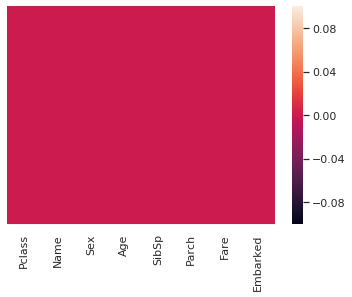

In [10]:
sns.heatmap(train.isnull(),yticklabels=False,cbar='BuPu')


# **Feature Engineering**

**Title**

Lets take out the Mr, Miss, etc from the name section, and create a new column names title!

In [11]:
#TITLE

train_test_data = [train, test] # combining train and test dataset

for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 1, 
                 "Master": 0, "Dr": 1, "Rev": 0, "Col": 0, "Major": 0, "Mlle": 1,"Countess": 1,
                 "Ms": 1, "Lady": 1, "Jonkheer": 1, "Don": 0, "Dona" : 1, "Mme": 0,"Capt": 0,"Sir": 0 }
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    


**Sex**


We can make male and female into catagorical variables such as 0 and 1

In [12]:
    
sex_mapping = {"male": 0, "female":1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)


**Embarked**

Lets test to see if there is any correlation with Pclass and Embarked 

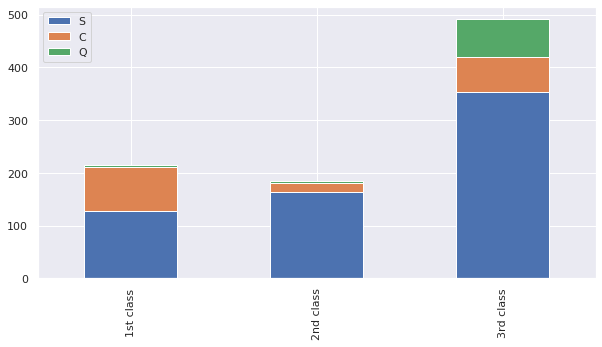

In [13]:
Pclass1 = train_data[train_data['Pclass'] == 1]['Embarked'].value_counts()
Pclass2 = train_data[train_data['Pclass'] == 2]['Embarked'].value_counts()
Pclass3 = train_data[train_data['Pclass'] == 3]['Embarked'].value_counts()

df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar',stacked=True, figsize=(10,5))

We can assign each embarked value to a numberical value for training later!

In [14]:
for data in train_test_data:
    data['Embarked'] = data['Embarked'].fillna("S")
    
embarked_mapping = {"S": 0, "C": 1, "Q": 2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

**Family Size**

Parch ( Parent & child ) and Sibsp( Sibling & Spouse ) are both contributing factors to family size, so lets make a new column called family size, and drop the other ones.

In [15]:
train["FamilySize"] = train['SibSp'] + train['Parch'] + 1
test["FamilySize"] = test['SibSp'] + test['Parch'] + 1

# **Correlations**

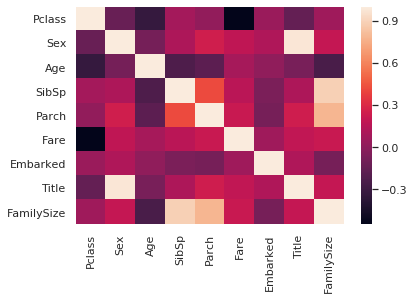

In [16]:
sns.heatmap(train.corr(),cbar='plasma')


In [17]:
train.drop(['Name'], axis = 1, inplace=True)
test.drop(['Name'], axis = 1, inplace=True)

In [18]:
train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
0,3,0,22.0,1,0,7.2500,0,0,2
1,1,1,38.0,1,0,71.2833,1,1,2
2,3,1,26.0,0,0,7.9250,0,1,1
3,1,1,35.0,1,0,53.1000,0,1,2
4,3,0,35.0,0,0,8.0500,0,0,1


In [19]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
0,3,0,34.5,0,0,7.8292,2,0,1
1,3,1,47.0,1,0,7.0000,0,1,2
2,2,0,62.0,0,0,9.6875,2,0,1
3,3,0,27.0,0,0,8.6625,0,0,1
4,3,1,22.0,1,1,12.2875,0,1,3


# **PreProcessing**

**Now that our data looks good, lets get ready to build our models!**

In [20]:
#imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

We should scale the values in the data, so that the neural network can train better!

In [21]:
continuous = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'FamilySize']

scaler = StandardScaler()

for var in continuous:
    train[var] = train[var].astype('float64')
    train[var] = scaler.fit_transform(train[var].values.reshape(-1, 1))
for var in continuous:
    test[var] = test[var].astype('float64')
    test[var] = scaler.fit_transform(test[var].values.reshape(-1, 1))

In [22]:
train.describe(include='all').T


,count,mean,std,min,25%,50%,75%,max
Pclass,891.0,-8.772133e-17,1.000562,-1.566107,-0.369365,0.827377,0.827377,0.827377
Sex,891.0,3.524130e-01,0.477990,0.000000,0.000000,0.000000,1.000000,1.000000
Age,891.0,2.232906e-16,1.000562,-2.253155,-0.592481,0.000000,0.407926,3.870872
SibSp,891.0,4.386066e-17,1.000562,-0.474545,-0.474545,-0.474545,0.432793,6.784163
Parch,891.0,5.382900e-17,1.000562,-0.473674,-0.473674,-0.473674,-0.473674,6.974147
Fare,891.0,3.987333e-18,1.000562,-0.648422,-0.489148,-0.357391,-0.024246,9.667167
Embarked,891.0,3.613917e-01,0.635673,0.000000,0.000000,0.000000,1.000000,2.000000
Title,891.0,3.591470e-01,0.480020,0.000000,0.000000,0.000000,1.000000,1.000000
FamilySize,891.0,-2.392400e-17,1.000562,-0.560975,-0.560975,-0.560975,0.059160,5.640372


# **Logistic Regression**

* `train` - stores training set data
* `y_train` - stores training set results
* `test` - stores test set data on which predictions have to be made

First, fit the model using `train` and `y_train` and then make prediction on `test`
<a id='main'></a>

In [31]:
from sklearn.linear_model import LogisticRegression
w=LogisticRegression(solver='lbfgs',verbose=1).fit(train,y_train)
# w.predict_proba(train)
# w.predict(train)
# w.score(train,y_train)
w.predict(test)
#Write code for logistic regression here

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

**Create Predictions**
<a id='main2'></a>

In [1]:
#Write code to generate predictions file
# writer=
import csv
output_data=pd.read_csv("./titanic/ouput.csv")
y_test=output_data.copy()
y_test=y_test['Survived']
# print(y_test)
# f=w.predict(test)
# print(f)

with open("./titanic/output_pred.csv","w") as writer:
    write_pred=csv.writer(writer)
    f=w.predict(test)    
#     transform_row(row,f)
    write_pred.writerow(f)

w.score(test,y_test)
#     for val in f:
#         write_pred.writerow(val)

NameError: name 'pd' is not defined